{/* cspell:ignore ebit operatorname */}



# Qiskit implementation

In this lesson, we implement some of the ideas from the lesson on entanglement in action, using Qiskit.



In [1]:
from qiskit import __version__

print(__version__)

1.4.4


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

Here is a quantum circuit implementation of the teleportation protocol.



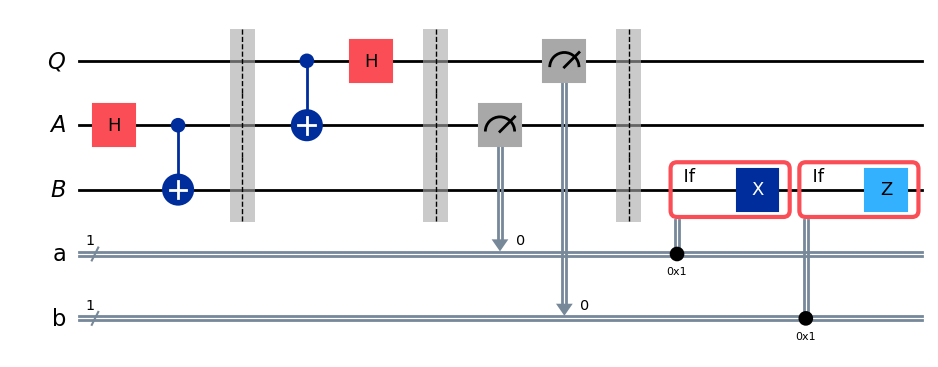

In [4]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw(output="mpl"))

The circuit makes use of a few features of Qiskit that we've not yet seen in previous lessons, including the `barrier` and `if_test` functions.
The `barrier` function creates a visual separation making the circuit diagram more readable, and it also prevents Qiskit from performing various simplifications and optimizations across the barrier during compilation when circuits are run on real hardware.
The `if_test` function applies an operation conditionally depending on a classical bit or register.

The circuit first initializes $(\mathsf{A},\mathsf{B})$ to be in a $\vert \phi^+\rangle$ state (which is not part of the protocol itself), followed by Alice's operations, then her measurements, and finally Bob's operations.
To test that the protocol works correctly, we'll apply a randomly generated single-qubit gate to the initialized $\vert 0\rangle$ state of $\mathsf{Q}$ to obtain a random quantum state vector to be teleported. By applying the inverse (as in, the conjugate transpose) of that gate to $\mathsf{B}$ after the protocol is run, we can verify that the state was teleported by measuring to see that it has returned to the $\vert 0\rangle$ state.

First we'll randomly choose a unitary qubit gate.



In [5]:
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)

display(array_to_latex(random_gate.to_matrix()))

<IPython.core.display.Latex object>

Now we'll create a new testing circuit that first applies our random gate to $\mathsf{Q},$ then runs the teleportation circuit, and finally applies the inverse of our random gate to the qubit $\mathsf{B}$ and measures.
The outcome should be $0$ with certainty.



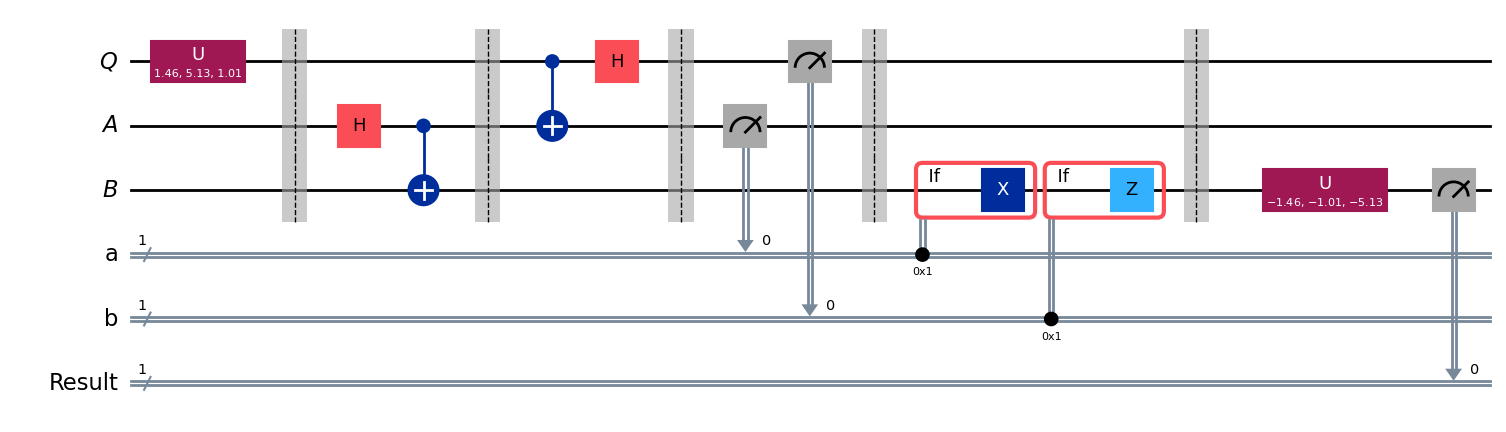

In [6]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q

test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above.

test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure.

test.append(random_gate.inverse(), ebit1)
result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw(output="mpl"))

Finally, let's run the Aer simulator on this circuit and plot a histogram of the outputs.
We'll see the statistics for all three classical bits:
the bottom/leftmost bit should always be $0,$ indicating that the qubit $\mathsf{Q}$ was successfully teleported into $\mathsf{B},$ while the other two bits should be roughly uniform.



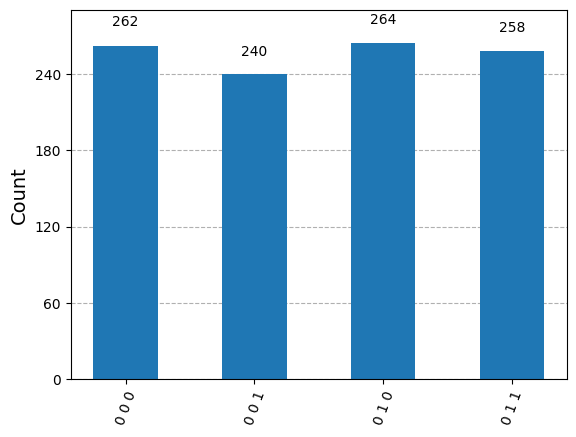

In [7]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

We can also filter the statistics to focus solely on the test result qubit if we wish, like this:



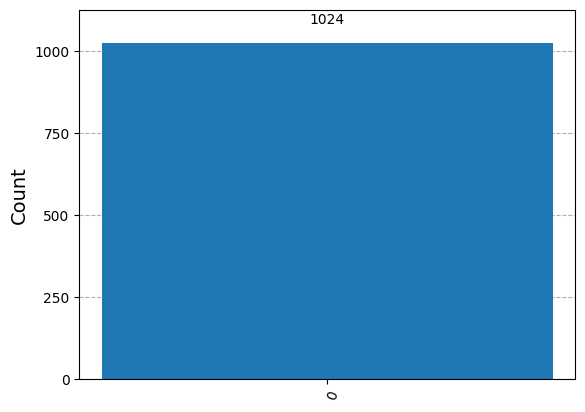

In [8]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

## Superdense coding

Superdense coding is a protocol that, in some sense, achieves a complementary aim to teleportation.
Rather than allowing for the transmission of one qubit using two classical bits of communication (at the cost of one e-bit of entanglement), it allows for the transmission of two classical bits using one qubit of quantum communication (again, at the cost of one e-bit of entanglement).

In greater detail, we have a sender (Alice) and a receiver (Bob) that share one e-bit of entanglement.
According to the conventions in place for the lesson, this means that Alice holds a qubit $\mathsf{A},$ Bob holds a qubit $\mathsf{B},$ and together the pair $(\mathsf{A},\mathsf{B})$ is in the state $\vert\phi^+\rangle.$
Alice wishes to transmit two classical bits to Bob, which we'll denote by $c$ and $d,$ and she will accomplish this by sending him one qubit.

It is reasonable to view this feat as being less interesting than the one that teleportation accomplishes.
Sending qubits is likely to be so much more difficult than sending classical bits for the foreseeable future that trading one qubit of quantum communication for two bits of classical communication, at the cost of an e-bit no less, hardly seems worth it.
However, this does not imply that superdense coding is not interesting, for it most certainly is.

Fitting the theme of the lesson, one reason why superdense coding is interesting is that it demonstrates a concrete and (in the context of information theory) rather striking use of entanglement.
A famous theorem in quantum information theory, known as *Holevo's theorem*, implies that without the use of a shared entangled state, it is impossible to communicate more than one bit of classical information by sending a single qubit.
(Holevo's theorem is more general than this.
Its precise statement is technical and requires explanation, but this is one consequence of it.)
So, through superdense coding, shared entanglement effectively allows for the *doubling* of the classical information-carrying capacity of sending qubits.



### Protocol

The following quantum circuit diagram describes the superdense coding protocol:

![Superdense coding circuit](/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/superdense-coding.avif)

In words, here is what Alice does:

1.  If $d=1,$ Alice performs a $Z$ gate on her qubit $\mathsf{A}$ (and if $d=0$ she does not).

2.  If $c=1,$ Alice performs an $X$ gate on her qubit $\mathsf{A}$ (and if $c=0$ she does not).

Alice then sends her qubit $\mathsf{A}$ to Bob.

What Bob does when he receives the qubit $\mathsf{A}$ is to first perform a controlled-NOT gate, with $\mathsf{A}$ being the control and $\mathsf{B}$ being the target, and then he applies a Hadamard gate to $\mathsf{A}.$
He then measures $\mathsf{B}$ to obtain $c$ and $\mathsf{A}$ to obtain $d,$ with standard basis measurements in both cases.

### Analysis

The idea behind this protocol is simple:
Alice effectively chooses which Bell state she would like to be sharing with Bob,
she sends Bob her qubit, and Bob measures to determine which Bell state Alice chose.

That is, they initially share $\vert\phi^+\rangle,$ and depending upon the bits $c$ and $d,$ Alice either leaves this state alone or shifts it to one of the other Bell states by applying $\mathbb{I},$ $X,$ $Z,$ or $XZ$ to her qubit
$\mathsf{A}.$

$$
\begin{aligned}
(\mathbb{I} \otimes \mathbb{I}) \vert \phi^+ \rangle & = \vert \phi^+\rangle \\
(\mathbb{I} \otimes Z) \vert \phi^+ \rangle & = \vert \phi^-\rangle \\
(\mathbb{I} \otimes X) \vert \phi^+ \rangle & = \vert \psi^+\rangle \\
(\mathbb{I} \otimes XZ) \vert \phi^+ \rangle & = \vert \psi^-\rangle
\end{aligned}
$$

Bob's actions have the following effects on the four Bell states:

$$
\begin{aligned}
\vert \phi^+\rangle & \mapsto \vert 00\rangle\\
\vert \phi^-\rangle & \mapsto \vert 01\rangle\\
\vert \psi^+\rangle & \mapsto \vert 10\rangle\\
\vert \psi^-\rangle & \mapsto -\vert 11\rangle\\
\end{aligned}
$$

This can be checked directly, by computing the results of Bob's operations on these states one at a time.

So, when Bob performs his measurements, he is able to determine which Bell state Alice chose.
To verify that the protocol works correctly is a matter of checking each case:

*   If $cd = 00,$ then the state of $(\mathsf{B},\mathsf{A})$ when Bob receives $\mathsf{A}$ is $\vert \phi^+\rangle.$ He transforms this state into $\vert 00\rangle$ and obtains $cd = 00.$

*   If $cd = 01,$ then the state of $(\mathsf{B},\mathsf{A})$ when Bob receives $\mathsf{A}$ is $\vert \phi^-\rangle.$ He transforms this state into $\vert 01\rangle$ and obtains $cd = 01.$

*   If $cd = 10,$ then the state of $(\mathsf{B},\mathsf{A})$ when Bob receives $\mathsf{A}$ is $\vert \psi^+\rangle.$ He transforms this state into $\vert 10\rangle$ and obtains $cd = 10.$

*   If $cd = 11,$ then the state of $(\mathsf{B},\mathsf{A})$ when Bob receives $\mathsf{A}$ is $\vert \psi^-\rangle.$ He transforms this state into $-\vert 11\rangle$ and obtains $cd = 11.$ (The negative-one phase factor has no effect here.)



### Superdense coding implementation

Here is a simple implementation of superdense coding where we specify the circuit itself depending on the bits to be transmitted. First we'll choose two bits to be transmitted. (Later we'll choose them randomly, but for now we'll just make an arbitrary choice.)



In [8]:
c = "1"
d = "0"

Now we'll build the circuit accordingly. Here we'll allow Qiskit to use the default names for the qubits: $\mathsf{q}_0$ for the top qubit and $\mathsf{q}_1$ for the bottom one.



In [9]:
protocol = QuantumCircuit(2)

# Prepare ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# Alice's operations
if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)
protocol.barrier()

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw(output="mpl"))

<Image src="/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/extracted-outputs/05ae9b94-0.avif" alt="Output of the previous code cell" />

Not much is new here, except the `measure_all` function, which measures all of the qubits and puts the results into a single classical register (and therefore having two bits in this case).

Running the Aer simulator produces the expected output.



In [10]:
result = AerSimulator().run(protocol).result()
statistics = result.get_counts()

for outcome, frequency in statistics.items():
    print(f"Measured {outcome} with frequency {frequency}")

display(plot_histogram(statistics))

Measured 10 with frequency 1024


<Image src="/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/extracted-outputs/6309a901-c3da-4b7d-b762-c6a7b542457b-1.avif" alt="Output of the previous code cell" />

Now let's use an additional qubit as a random bit generator — essentially to flip fair coins. We'll use it to randomly choose $c$ and $d,$ and then run the superdense coding protocol.



In [11]:
rbg = QuantumRegister(1, "coin")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Use the 'coin' qubit twice to generate Alice's bits c and d.
test.h(rbg)
test.measure(rbg, Alice_c)
test.h(rbg)
test.measure(rbg, Alice_d)
test.barrier()

# Now the protocol runs, starting with Alice's actions, which depend
# on her bits.
with test.if_test((Alice_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_c, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0, Bob_d)
test.measure(ebit1, Bob_c)

display(test.draw(output="mpl"))

<Image src="/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/extracted-outputs/06e461e9-0.avif" alt="Output of the previous code cell" />

Running the Aer simulator shows the results: Alice and Bob's classical bits always agree.



In [12]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

<Image src="/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/extracted-outputs/77fd1434-0.avif" alt="Output of the previous code cell" />

## The CHSH game

The last example to be discussed in this lesson is not a protocol, but a *game* known as the
*CHSH game*.

When we speak of a game in this context, we're not talking about something that's meant to be played for fun or sport, but rather a mathematical abstraction in the sense of *game theory*.
Mathematical abstractions of games are studied in economics and computer science, for instance, and they are both fascinating and useful.

The letters CHSH refer to the authors — John Clauser, Michael Horne, Abner Shimony, and Richard Holt — of a 1969 paper where the example was first described.
They did not describe the example as a game, but rather as an experiment.
Its description as a game, however, is both natural and intuitive.

The CHSH game falls within a class of games known as *nonlocal games*.
Nonlocal games are incredibly interesting and have deep connections to physics, computer science, and mathematics — holding mysteries that still remain unsolved.
We'll begin the section by explaining what nonlocal games are, and then we'll focus in on the CHSH game and what makes it interesting.

### Nonlocal games

A nonlocal game is a *cooperative game* where two players, Alice and Bob, work together to achieve a particular outcome.
The game is run by a *referee*, who behaves according to strict guidelines that are known to Alice and Bob.

Alice and Bob can prepare for the game however they choose, but once the game starts they are *forbidden from communicating*.
We might imagine the game taking place in a secure facility of some sort — as if the referee is playing the role of a detective and Alice and Bob are suspects being interrogated in different rooms.
But another way to think about the set-up is that Alice and Bob are separated by a vast distance, and communication is prohibited because the speed of light doesn't allow for it within the running time of the game.
That is to say, if Alice tries to send a message to Bob, the game will be over by the time he receives it, and vice versa.

The way a nonlocal game works is that the referee first asks Alice and Bob one question each.
We'll use the letter $x$ to refer to Alice's question and $y$ to refer to Bob's question.
Here we're thinking of $x$ and $y$ as being classical states, and in the CHSH game $x$ and $y$ are bits.

The referee uses *randomness* to select these questions.
To be precise, there is some probability $p(x,y)$ associated with each possible pair $(x,y)$ of questions, and the referee has vowed to choose the questions randomly, at the time of the game, in this way.
Everyone, including Alice and Bob, knows these probabilities — but nobody knows specifically which pair $(x,y)$ will be chosen until the game begins.

After Alice and Bob receive their questions, they must then provide answers: Alice's answer is $a$ and Bob's answer is $b.$
Again, these are classical states in general, and bits in the CHSH game.

At this point the referee makes a decision: Alice and Bob either *win* or *lose* depending on whether or not the pair of answers $(a,b)$ is deemed correct for the pair of questions $(x,y)$ according to some fixed set of rules.
Different rules mean different games, and the rules for the CHSH game specifically are described in the section following this one.
As was already suggested, the rules are known to everyone.

The following diagram provides a graphic representation of the interactions.

![Nonlocal game](/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/nonlocal-game.avif)

It is the uncertainty about which questions will be asked, and specifically the fact that each player doesn't know the other player's question, that makes nonlocal games challenging for Alice and Bob — just like colluding suspects in different rooms trying to keep their story straight.

A precise description of the referee defines an instance of a nonlocal game.
This includes a specification of the probabilities $p(x,y)$ for each question pair along with the rules
that determine whether each pair of answers $(a,b)$ wins or loses for each possible question pair $(x,y).$

We'll take a look at the CHSH game momentarily, but before that let us briefly acknowledge that it's also interesting to consider other nonlocal games.
In fact, it's extremely interesting; there are some pretty simple nonlocal games for which it's currently not known how well Alice and Bob can play using entanglement.
The set-up is simple, but there's complexity at work — and for some games it can be impossibly difficult to compute best or near-best strategies for Alice and Bob.
This is the surprisingly unintuitive nature of the nonlocal games model.

### CHSH game description

Here is the precise description of the CHSH game, where (as above) $x$ is Alice's question, $y$ is Bob's question, $a$ is Alice's answer, and $b$ is Bob's answer:

*   The questions and answers are all bits: $x,y,a,b\in\{0,1\}.$

*   The referee chooses the questions $(x,y)$ *uniformly at random*. That is, each of the four possibilities, $(0,0),$ $(0,1),$ $(1,0),$ and $(1,1),$ is selected with probability $1/4.$

*   The answers $(a,b)$ *win* for the questions $(x,y)$ if $a\oplus b = x\wedge y$ and *lose* otherwise. The following table expresses this rule by listing the winning and losing conditions on the answers $(a,b)$ for each pair of questions $(x,y).$

$$
\begin{array}{ccc}
(x,y) & \text{win} & \text{lose} \\[1mm]\hline
\rule{0mm}{4mm}(0,0) & a = b & a \neq b \\[1mm]
(0,1) & a = b & a \neq b \\[1mm]
(1,0) & a = b & a \neq b \\[1mm]
(1,1) & a \neq b & a = b
\end{array}
$$



### Limitation of classical strategies

Now let's consider strategies for Alice and Bob in the CHSH game, beginning with *classical* strategies.

#### Deterministic strategies

We'll start with *deterministic* strategies, where Alice's answer $a$ is a function of the question $x$ that she receives, and likewise Bob's answer $b$ is a function of the question $y$ he receives.
So, for instance, we may write $a(0)$ to represent Alice's answer when her question is $0,$ and $a(1)$ to represent Alice's answer when her question is $1.$

No deterministic strategy can possibly win the CHSH game every time.
One way to understand this is simply to go one-by-one through all of the possible deterministic strategies and check that every one of them loses for at least one of the four possible question pairs.
Alice and Bob can each choose from four possible functions from one bit to one bit — which we encountered in the lesson on [Single systems](/learning/courses/basics-of-quantum-information/single-systems/introduction) — and so there are $16$ different deterministic strategies in total to check.

We can also reason this analytically.
If Alice and Bob's strategy wins when $(x,y) = (0,0),$ then it must be that $a(0) = b(0);$
if their strategy wins when $(x,y) = (0,1),$ then $a(0) = b(1);$ and similarly,
if the strategy wins for $(x,y)=(1,0)$ then $a(1) = b(0).$
So, if their strategy wins for all three possibilities, then

$$
b(1) = a(0) = b(0) = a(1).
$$

This implies that the strategy loses in the final case $(x,y) = (1,1),$ and for here winning requires that
$a(1) \neq b(1).$
Thus, there can be no deterministic strategy that wins every time.

On the other hand, it is easy to find deterministic strategies that win in three of the four cases, such as $a(0)=a(1)=b(0)=b(1)=0.$
From this we conclude that the maximum probability for Alice and Bob to win using a deterministic strategy is $3/4.$

#### Probabilistic strategies

As we just concluded, Alice and Bob cannot do better than winning the CHSH game 75% of the time using a deterministic strategy.
But what about a probabilistic strategy?
Could it help Alice and Bob to use randomness — including the possibility of *shared randomness*, where their random choices are correlated?

It turns out that probabilistic strategies don't help at all to increase the probability that Alice and Bob win.
This is because every probabilistic strategy can alternatively be viewed as a random selection of a deterministic strategy, just like (as was mentioned in the [Single systems](/learning/courses/basics-of-quantum-information/single-systems/introduction) lesson) probabilistic operations can be viewed as random selections of deterministic operations.
The average is never larger than the maximum, and so it follows that probabilistic strategies don't offer any advantage in terms of their overall winning probability.

Thus, winning with probability $3/4$ is the best that Alice and Bob can do using any classical strategy, whether deterministic or probabilistic.

### CHSH game strategy

A natural question to ask at this point is whether Alice and Bob can do any better using a *quantum* strategy.
In particular, if they share an entangled quantum state as the following figure suggests, which they could have prepared prior to playing the game, can they increase their winning probability?

![Nonlocal game with entanglement](/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/nonlocal-game-entanglement.avif)

The answer is yes, and this is the main point of the example and why it's so interesting.
So let's see exactly how Alice and Bob can do better in this game using entanglement.

#### Required vectors and matrices

The first thing we need to do is to define a qubit state vector $\vert \psi_{\theta}\rangle,$ for each real number
$\theta$ (which we'll think of as an angle measured in radians) as follows.

$$
\vert\psi_{\theta}\rangle = \cos(\theta)\vert 0\rangle + \sin(\theta) \vert 1\rangle
$$

Here are some simple examples:

$$
\begin{aligned}
  \vert\psi_{0}\rangle & = \vert 0\rangle \\
  \vert\psi_{\pi/2}\rangle & = \vert 1\rangle \\
  \vert\psi_{\pi/4}\rangle & = \vert + \rangle \\
  \vert\psi_{-\pi/4}\rangle & = \vert - \rangle
\end{aligned}
$$

We also have the following examples, which arise in the analysis below:

$$
\begin{aligned}
  \vert\psi_{-\pi/8}\rangle & = \frac{\sqrt{2 + \sqrt{2}}}{2}\vert 0\rangle -\frac{\sqrt{2 - \sqrt{2}}}{2}\vert 1\rangle \\[1mm]
  \vert\psi_{\pi/8}\rangle & = \frac{\sqrt{2 + \sqrt{2}}}{2}\vert 0\rangle + \frac{\sqrt{2 - \sqrt{2}}}{2}\vert 1\rangle \\[1mm]
  \vert\psi_{3\pi/8}\rangle & = \frac{\sqrt{2 - \sqrt{2}}}{2}\vert 0\rangle + \frac{\sqrt{2 + \sqrt{2}}}{2}\vert 1\rangle \\[1mm]
  \vert\psi_{5\pi/8}\rangle & = -\frac{\sqrt{2 - \sqrt{2}}}{2}\vert 0\rangle + \frac{\sqrt{2 + \sqrt{2}}}{2}\vert 1\rangle
\end{aligned}
$$

Looking at the general form, we see that the inner product between any two of these vectors has this formula:

$$
\langle \psi_{\alpha} \vert \psi_{\beta} \rangle
= \cos(\alpha)\cos(\beta) + \sin(\alpha)\sin(\beta)
= \cos(\alpha-\beta).
\tag{3}
$$

In detail, there are only real number entries in these vectors, so there are no complex conjugates to worry about:
the inner product is the product of the cosines plus the product of the sines.
Using one of the *angle addition formulas* from trigonometry leads to the simplification above.
This formula reveals the geometric interpretation of the inner product between real unit vectors as the cosine of the angle between them.

If we compute the inner product of the *tensor product* of any two of these vectors with the $\vert \phi^+\rangle$ state, we obtain a similar expression, except that it has a $\sqrt{2}$ in the denominator:

$$
\langle \psi_{\alpha} \otimes \psi_{\beta} \vert \phi^+ \rangle
= \frac{\cos(\alpha)\cos(\beta) + \sin(\alpha)\sin(\beta)}{\sqrt{2}}
= \frac{\cos(\alpha-\beta)}{\sqrt{2}}.
\tag{4}
$$

Our interest in this particular inner product will become clear shortly, but for now we're simply observing this as a formula.

Next, define a unitary matrix $U_{\theta}$ for each angle $\theta$ as follows.

$$
U_{\theta} = \vert 0 \rangle \langle \psi_{\theta} \vert + \vert 1\rangle\langle \psi_{\theta+\pi/2} \vert
$$

Intuitively speaking, this matrix transforms $\vert\psi_{\theta}\rangle$ into $\vert 0\rangle$ and $\vert \psi_{\theta + \pi/2}\rangle$ into $\vert 1\rangle.$
To check that this is a unitary matrix, a key observation is that the vectors $\vert\psi_{\theta}\rangle$ and $\vert\psi_{\theta + \pi/2}\rangle$ are orthogonal for every angle $\theta$:

$$
\langle \psi_{\theta} \vert \psi_{\theta + \pi/2} \rangle = \cos(\pi/2) = 0.
$$

Thus, we find that

$$
\begin{aligned}
U_{\theta} U_{\theta}^{\dagger}
& = \bigl(\vert 0 \rangle \langle \psi_{\theta} \vert + \vert 1\rangle\langle \psi_{\theta+\pi/2} \vert\bigr)
\bigl(\vert \psi_{\theta} \rangle \langle 0 \vert + \vert \psi_{\theta+\pi/2}\rangle\langle 1 \vert\bigr) \\[1mm]
& =
\vert 0 \rangle \langle \psi_{\theta} \vert \psi_{\theta} \rangle \langle 0 \vert
+ \vert 0 \rangle \langle \psi_{\theta} \vert \psi_{\theta+\pi/2} \rangle \langle 1 \vert
+ \vert 1 \rangle \langle \psi_{\theta+\pi/2} \vert \psi_{\theta} \rangle \langle 0 \vert
+ \vert 1 \rangle \langle \psi_{\theta+\pi/2} \vert \psi_{\theta+\pi/2} \rangle \langle 1 \vert \\[1mm]
& =
\vert 0 \rangle \langle 0 \vert + \vert 1 \rangle \langle 1 \vert\\[1mm]
& = \mathbb{I}.
\end{aligned}
$$

We may alternatively write this matrix explicitly as

$$
U_{\theta}
= \begin{pmatrix}
\cos(\theta) & \sin(\theta)\\[1mm]
\cos(\theta+ \pi/2) & \sin(\theta + \pi/2)
\end{pmatrix}
= \begin{pmatrix}
\cos(\theta) & \sin(\theta)\\[1mm]
-\sin(\theta) & \cos(\theta)
\end{pmatrix}.
$$

This is an example of a *rotation matrix*, and specifically it rotates two-dimensional vectors with real number entries by an angle of $-\theta$ about the origin.
If we follow a standard convention for naming and parameterizing rotations of various forms, we have
$U_{\theta} = R_y(-2\theta)$ where

$$
R_y(\theta) = \begin{pmatrix}
\cos(\theta/2) & -\sin(\theta/2)\\[1mm]
\sin(\theta/2) & \cos(\theta/2)
\end{pmatrix}.
$$



#### Strategy description

Now we can describe the quantum strategy.

*   **Set-up:** Alice and Bob start the game sharing an e-bit: Alice holds a qubit $\mathsf{A},$ Bob holds a qubit $\mathsf{B},$ and together the two qubits $(\mathsf{X},\mathsf{Y})$ are in the $\vert\phi^+\rangle$ state.

*   **Alice's actions:**

    *   If Alice receives the question $x=0,$ she applies $U_{0}$ to her qubit $\mathsf{A}.$
    *   If Alice receives the question  $x=1,$ she applies $U_{\pi/4}$ to her qubit $\mathsf{A}.$

    The operation Alice performs on $\mathsf{A}$ may alternatively be described like this:

    $$
    \begin{cases}
    U_0 & \text{if $x = 0$}\\
    U_{\pi/4} & \text{if $x = 1$}
    \end{cases}
    $$

    After Alice applies this operation, she measures $\mathsf{A}$ with a standard basis measurement and sets her answer $a$ to be the measurement outcome.

*   **Bob's actions:**

    *   If Bob receives the question $y=0,$ he applies $U_{\pi/8}$ to his qubit $\mathsf{B}.$
    *   If Bob receives the question $y=1,$ he applies $U_{-\pi/8}$ to his qubit $\mathsf{B}.$

    Like we did for Alice, we can express Bob's operation on $\mathsf{B}$ like this:

    $$
    \begin{cases}
    U_{\pi/8} & \text{if $y = 0$}\\
    U_{-\pi/8} & \text{if $y = 1$}
    \end{cases}
    $$

    After Bob applies this operation, he measures $\mathsf{B}$ with a standard basis measurement and sets his answer $b$ to be the measurement outcome.

Here is a quantum circuit diagram that describes this strategy:

![CHSH game circuit](/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/CHSH.avif)

In this diagram we see two ordinary controlled gates, one for $U_{-\pi/8}$ on the top and one for $U_{\pi/4}$ on the bottom.
We also have two gates that look like controlled gates, one for $U_{\pi/8}$ on the top and one for $U_{0}$ on the bottom, except that the circle representing the control is not filled in.
This denotes a different type of controlled gate where the gate is performed if the control is set to $0$ (rather than $1$ like an ordinary controlled gate).
So, effectively, Bob performs $U_{\pi/8}$ on his qubit if $y=0$ and $U_{-\pi/8}$ if $y=1;$
and Alice performs $U_0$ on her qubit if $x=0$ and $U_{\pi/4}$ if $x=1,$ which is consistent with the description of the protocol in words above.

It remains to figure out how well this strategy for Alice and Bob works.
We'll do this by going through the four possible question pairs individually.



#### Case-by-case analysis

*   Case 1:  $(x,y) = (0,0).$

    In this case Alice performs $U_{0}$ on her qubit and Bob performs $U_{\pi/8}$ on his, so the state of the two qubits $(\mathsf{A},\mathsf{B})$ after they perform their operations is

    $$
    \begin{aligned}
    \bigl(U_0 \otimes U_{\pi/8}\bigr) \vert \phi^+\rangle
    & =
    \vert 00 \rangle \langle \psi_0 \otimes \psi_{\pi/8}\vert \phi^+\rangle
    + \vert 01 \rangle \langle \psi_0 \otimes\psi_{5\pi/8}\vert \phi^+\rangle \\
    & \qquad + \vert 10 \rangle \langle \psi_{\pi/2} \otimes \psi_{\pi/8}\vert \phi^+\rangle
    + \vert 11 \rangle \langle \psi_{\pi/2} \otimes \psi_{5\pi/8}\vert \phi^+\rangle\\[2mm]
    & = \frac{
        \cos\bigl(-\frac{\pi}{8}\bigr) \vert 00\rangle
      + \cos\bigl(-\frac{5\pi}{8}\bigr) \vert 01\rangle
      + \cos\bigl(\frac{3\pi}{8}\bigr) \vert 10\rangle
      + \cos\bigl(-\frac{\pi}{8}\bigr) \vert 11\rangle}{\sqrt{2}}.
    \end{aligned}
    $$

    The probabilities for the four possible answer pairs $(a,b)$ are therefore as follows.

    $$
    \begin{aligned}
    \operatorname{Pr}\bigl((a,b)=(0,0)\bigr) & = \frac{1}{2}\cos^2\Bigl(-\frac{\pi}{8}\Bigr) = \frac{2+\sqrt{2}}{8} \\[2mm]
    \operatorname{Pr}\bigl((a,b)=(0,1)\bigr) & = \frac{1}{2}\cos^2\Bigl(-\frac{5\pi}{8}\Bigr) = \frac{2-\sqrt{2}}{8}\\[2mm]
    \operatorname{Pr}\bigl((a,b)=(1,0)\bigr) & = \frac{1}{2}\cos^2\Bigl(\frac{3\pi}{8}\Bigr) = \frac{2-\sqrt{2}}{8}\\[2mm]
    \operatorname{Pr}\bigl((a,b)=(1,1)\bigr) & = \frac{1}{2}\cos^2\Bigl(-\frac{\pi}{8}\Bigr) = \frac{2+\sqrt{2}}{8}
    \end{aligned}
    $$

    We can then obtain the probabilities that $a=b$ and $a\neq b$ by summing.

    $$
    \begin{aligned}
    \operatorname{Pr}(a = b) & = \frac{2 + \sqrt{2}}{4}\\[2mm]
    \operatorname{Pr}(a \neq b) & = \frac{2 - \sqrt{2}}{4}
    \end{aligned}
    $$

    For the question pair $(0,0),$ Alice and Bob win if $a=b,$ and therefore they win in this case with probability

    $$
    \frac{2 + \sqrt{2}}{4}.
    $$

*   Case 2:  $(x,y) = (0,1).$

    In this case Alice performs $U_{0}$ on her qubit and Bob performs $U_{-\pi/8}$ on his, so the state of the two qubits $(\mathsf{A},\mathsf{B})$ after they perform their operations is

    $$
    \begin{aligned}
    \bigl(U_0 \otimes U_{-\pi/8}\bigr) \vert \phi^+\rangle
    & =
    \vert 00 \rangle \langle \psi_0 \otimes \psi_{-\pi/8}\vert \phi^+\rangle
    + \vert 01 \rangle \langle \psi_0 \otimes\psi_{3\pi/8}\vert \phi^+\rangle \\
    & \qquad + \vert 10 \rangle \langle \psi_{\pi/2} \otimes \psi_{-\pi/8}\vert \phi^+\rangle
    + \vert 11 \rangle \langle \psi_{\pi/2} \otimes \psi_{3\pi/8}\vert \phi^+\rangle\\[2mm]
    & = \frac{
        \cos\bigl(\frac{\pi}{8}\bigr) \vert 00\rangle
      + \cos\bigl(-\frac{3\pi}{8}\bigr) \vert 01\rangle
      + \cos\bigl(\frac{5\pi}{8}\bigr) \vert 10\rangle
      + \cos\bigl(\frac{\pi}{8}\bigr) \vert 11\rangle}{\sqrt{2}}.
    \end{aligned}
    $$

    The probabilities for the four possible answer pairs $(a,b)$ are therefore as follows.

    $$
    \begin{aligned}
    \operatorname{Pr}\bigl((a,b)=(0,0)\bigr) & = \frac{1}{2}\cos^2\Bigl(\frac{\pi}{8}\Bigr) = \frac{2+\sqrt{2}}{8} \\[2mm]
    \operatorname{Pr}\bigl((a,b)=(0,1)\bigr) & = \frac{1}{2}\cos^2\Bigl(-\frac{3\pi}{8}\Bigr) = \frac{2-\sqrt{2}}{8}\\[2mm]
    \operatorname{Pr}\bigl((a,b)=(1,0)\bigr) & = \frac{1}{2}\cos^2\Bigl(\frac{5\pi}{8}\Bigr) = \frac{2-\sqrt{2}}{8}\\[2mm]
    \operatorname{Pr}\bigl((a,b)=(1,1)\bigr) & = \frac{1}{2}\cos^2\Bigl(\frac{\pi}{8}\Bigr) = \frac{2+\sqrt{2}}{8}
    \end{aligned}
    $$

    Again, we can obtain the probabilities that $a=b$ and $a\neq b$ by summing.

    $$
    \begin{aligned}
    \operatorname{Pr}(a = b) & = \frac{2 + \sqrt{2}}{4}\\[2mm]
    \operatorname{Pr}(a \neq b) & = \frac{2 - \sqrt{2}}{4}
    \end{aligned}
    $$

    For the question pair $(0,1),$ Alice and Bob win if $a=b,$ and therefore they win in this case with probability

    $$
    \frac{2 + \sqrt{2}}{4}.
    $$

*   Case 3:  $(x,y) = (1,0).$

    In this case Alice performs $U_{\pi/4}$ on her qubit and Bob performs $U_{\pi/8}$ on his, so the state of the two qubits $(\mathsf{A},\mathsf{B})$ after they perform their operations is

    $$
    \begin{aligned}
    \bigl(U_{\pi/4} \otimes U_{\pi/8}\bigr) \vert \phi^+\rangle
    & =
    \vert 00 \rangle \langle \psi_{\pi/4} \otimes \psi_{\pi/8}\vert \phi^+\rangle
    + \vert 01 \rangle \langle \psi_{\pi/4} \otimes\psi_{5\pi/8}\vert \phi^+\rangle \\
    & \qquad + \vert 10 \rangle \langle \psi_{3\pi/4} \otimes \psi_{\pi/8}\vert \phi^+\rangle
    + \vert 11 \rangle \langle \psi_{3\pi/4} \otimes \psi_{5\pi/8}\vert \phi^+\rangle\\[2mm]
    & = \frac{
        \cos\bigl(\frac{\pi}{8}\bigr) \vert 00\rangle
      + \cos\bigl(-\frac{3\pi}{8}\bigr) \vert 01\rangle
      + \cos\bigl(\frac{5\pi}{8}\bigr) \vert 10\rangle
      + \cos\bigl(\frac{\pi}{8}\bigr) \vert 11\rangle}{\sqrt{2}}.
    \end{aligned}
    $$

    The probabilities for the four possible answer pairs $(a,b)$ are therefore as follows.

    $$
    \begin{aligned}
    \operatorname{Pr}\bigl((a,b)=(0,0)\bigr) & = \frac{1}{2}\cos^2\Bigl(\frac{\pi}{8}\Bigr) = \frac{2+\sqrt{2}}{8} \\[2mm]
    \operatorname{Pr}\bigl((a,b)=(0,1)\bigr) & = \frac{1}{2}\cos^2\Bigl(-\frac{3\pi}{8}\Bigr) = \frac{2-\sqrt{2}}{8}\\[2mm]
    \operatorname{Pr}\bigl((a,b)=(1,0)\bigr) & = \frac{1}{2}\cos^2\Bigl(\frac{5\pi}{8}\Bigr) = \frac{2-\sqrt{2}}{8}\\[2mm]
    \operatorname{Pr}\bigl((a,b)=(1,1)\bigr) & = \frac{1}{2}\cos^2\Bigl(\frac{\pi}{8}\Bigr) = \frac{2+\sqrt{2}}{8}
    \end{aligned}
    $$

    We find, once again, that probabilities that $a=b$ and $a\neq b$ are as follows.

    $$
    \begin{aligned}
    \operatorname{Pr}(a = b) & = \frac{2 + \sqrt{2}}{4}\\[2mm]
    \operatorname{Pr}(a \neq b) & = \frac{2 - \sqrt{2}}{4}
    \end{aligned}
    $$

    For the question pair $(1,0),$ Alice and Bob win if $a=b,$ so they win in this case with probability

    $$
    \frac{2 + \sqrt{2}}{4}.
    $$

*   Case 4:  $(x,y) = (1,1).$

    The last case is a little bit different, as we might expect because the winning condition is different in this case. When $x$ and $y$ are both $1,$ Alice and Bob win when $a$ and $b$ are *different*. In this case Alice performs $U_{\pi/4}$ on her qubit and Bob performs $U_{-\pi/8}$ on his, so the state of the two qubits $(\mathsf{A},\mathsf{B})$ after they perform their operations is

    $$
    \begin{aligned}
    \bigl(U_{\pi/4} \otimes U_{-\pi/8}\bigr) \vert \phi^+\rangle
    & =
    \vert 00 \rangle \langle \psi_{\pi/4} \otimes \psi_{-\pi/8}\vert \phi^+\rangle
    + \vert 01 \rangle \langle \psi_{\pi/4} \otimes\psi_{3\pi/8}\vert \phi^+\rangle \\
    & \qquad + \vert 10 \rangle \langle \psi_{3\pi/4} \otimes \psi_{-\pi/8}\vert \phi^+\rangle
    + \vert 11 \rangle \langle \psi_{3\pi/4} \otimes \psi_{3\pi/8}\vert \phi^+\rangle\\[2mm]
    & = \frac{
        \cos\bigl(\frac{3\pi}{8}\bigr) \vert 00\rangle
      + \cos\bigl(-\frac{\pi}{8}\bigr) \vert 01\rangle
      + \cos\bigl(\frac{7\pi}{8}\bigr) \vert 10\rangle
      + \cos\bigl(\frac{3\pi}{8}\bigr) \vert 11\rangle}{\sqrt{2}}.
    \end{aligned}
    $$

    The probabilities for the four possible answer pairs $(a,b)$ are therefore as follows.

    $$
    \begin{aligned}
    \operatorname{Pr}\bigl((a,b)=(0,0)\bigr) & = \frac{1}{2}\cos^2\Bigl(\frac{3\pi}{8}\Bigr) = \frac{2-\sqrt{2}}{8} \\[2mm]
    \operatorname{Pr}\bigl((a,b)=(0,1)\bigr) & = \frac{1}{2}\cos^2\Bigl(-\frac{\pi}{8}\Bigr) = \frac{2+\sqrt{2}}{8}\\[2mm]
    \operatorname{Pr}\bigl((a,b)=(1,0)\bigr) & = \frac{1}{2}\cos^2\Bigl(\frac{7\pi}{8}\Bigr) = \frac{2+\sqrt{2}}{8}\\[2mm]
    \operatorname{Pr}\bigl((a,b)=(1,1)\bigr) & = \frac{1}{2}\cos^2\Bigl(\frac{3\pi}{8}\Bigr) = \frac{2-\sqrt{2}}{8}
    \end{aligned}
    $$

    The probabilities have effectively swapped places from in the three other cases.
    We obtain the probabilities that $a=b$ and $a\neq b$ by summing.

    $$
    \begin{aligned}
    \operatorname{Pr}(a = b) & = \frac{2 - \sqrt{2}}{4}\\[2mm]
    \operatorname{Pr}(a \neq b) & = \frac{2 + \sqrt{2}}{4}
    \end{aligned}
    $$

    For the question pair $(1,1),$ Alice and Bob win if $a\neq b,$ and therefore they win in this case with probability

    $$
    \frac{2 + \sqrt{2}}{4}.
    $$

They win in every case with the same probability:

$$
  \frac{2 + \sqrt{2}}{4} \approx 0.85.
$$

This is therefore the probability that they win overall.
That's significantly better than any classical strategy can do for this game; classical strategies have winning probability bounded by $3/4.$ And that makes this a very interesting example.

This happens to be the *optimal* winning probability for quantum strategies; we can't do any better than this, no matter what entangled state or measurements we choose.
This fact is known as *Tsirelson's inequality*, named for Boris Tsirelson who first proved it — and who first described the CHSH experiment as a game.



#### Geometric picture

It is possible to think about the strategy described above geometrically, which may be helpful for understanding the relationships among the various angles chosen for Alice and Bob's operations.

What Alice effectively does is to choose an angle $\alpha,$ depending on her question $x,$ and then to apply $U_{\alpha}$ to her qubit and measure.
Similarly, Bob chooses an angle $\beta,$ depending on $y,$ and then he applies $U_{\beta}$ to his qubit and measures.
We've chosen $\alpha$ and $\beta$ as follows.

$$
\begin{aligned}
\alpha & = \begin{cases}
0 & x=0\\
\pi/4 & x=1
\end{cases}\\[4mm]
\beta & = \begin{cases}
\pi/8 & y = 0\\
-\pi/8 & y = 1
\end{cases}
\end{aligned}
$$

For the moment, though, let's take $\alpha$ and $\beta$ to be arbitrary.
By choosing $\alpha,$ Alice effectively defines an orthonormal basis of vectors that looks like this:

![Basis for Alice](/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/alpha-basis.avif)

Bob does likewise, except that his angle is $\beta$:

![Basis for Bob](/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/beta-basis.avif)

The colors of the vectors correspond to Alice and Bob's answers: blue for $0$ and red for $1.$

Now, if we combine together ($3$) and ($4$) we get the formula

$$
\langle \psi_{\alpha} \otimes\psi_{\beta} \vert \phi^+ \rangle
= \frac{1}{\sqrt{2}} \langle \psi_{\alpha} \vert \psi_{\beta} \rangle;
$$

this works for all real numbers $\alpha$ and $\beta.$

Following the same sort of analysis that we went through above, but with $\alpha$ and $\beta$ being variables, we find this:

$$
  \begin{aligned}
  & \bigl(U_{\alpha} \otimes U_{\beta}\bigr) \vert \phi^+\rangle\\[1mm]
  & \qquad =
    \vert 00 \rangle \langle \psi_{\alpha} \otimes \psi_{\beta}\vert \phi^+\rangle
    + \vert 01 \rangle \langle \psi_{\alpha} \otimes\psi_{\beta + \pi/2}\vert \phi^+\rangle \\
  & \qquad \qquad + \vert 10 \rangle \langle \psi_{\alpha+\pi/2} \otimes \psi_{\beta}\vert \phi^+\rangle
    + \vert 11 \rangle \langle \psi_{\alpha+\pi/2} \otimes \psi_{\beta+\pi/2}\vert \phi^+\rangle\\[2mm]
  & \qquad = \frac{
        \langle \psi_\alpha \vert \psi_\beta \rangle \vert 00\rangle
      + \langle \psi_\alpha \vert \psi_{\beta+\pi/2} \rangle \vert 01\rangle
      + \langle \psi_{\alpha+\pi/2} \vert \psi_\beta \rangle \vert 10\rangle
      + \langle \psi_{\alpha+\pi/2} \vert \psi_{\beta+\pi/2} \rangle \vert 11\rangle
      }{\sqrt{2}}.
  \end{aligned}
$$

We conclude these two formulas:

$$
\begin{aligned}
\operatorname{Pr}(a = b)  & = \frac{1}{2} \vert \langle \psi_\alpha \vert \psi_\beta \rangle \vert^2
+ \frac{1}{2} \vert \langle \psi_{\alpha+\pi/2} \vert \psi_{\beta+\pi/2} \rangle \vert^2
= \cos^2(\alpha - \beta)\\[2mm]
\operatorname{Pr}(a \neq b) & = \frac{1}{2} \vert \langle \psi_\alpha \vert \psi_{\beta+\pi/2} \rangle \vert^2
+ \frac{1}{2} \vert \langle \psi_{\alpha+\pi/2} \vert \psi_\beta \rangle \vert^2
= \sin^2(\alpha - \beta).
\end{aligned}
$$

These equations can be connected to the figures above by imagining that we superimpose the bases chosen by Alice and Bob.

#### Explore the strategy

When $(x,y) = (0,0),$ Alice and Bob choose $\alpha = 0$ and $\beta = \pi/8,$ and by superimposing their bases we obtain this figure:

![Alice and Bob bases case 1](/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/strategy00.avif)

The angle between the red vectors is $\pi/8,$ which is the same as the angle between the two blue vectors.
The probability that Alice and Bob's outcomes agree is the cosine-squared of this angle,

$$
\cos^2\Bigl(\frac{\pi}{8}\Bigr) = \frac{2 + \sqrt{2}}{4},
$$

while the probability they disagree is the sine-squared of this angle,

$$
\sin^2\Bigl(\frac{\pi}{8}\Bigr) = \frac{2 - \sqrt{2}}{4}.
$$

When $(x,y) = (0,1),$ Alice and Bob choose $\alpha = 0$ and $\beta = -\pi/8,$ and by superimposing their bases we obtain this figure:

![Alice and Bob bases case 1](/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/strategy01.avif)

The angle between the red vectors is again $\pi/8,$ as is the angle between the blue vectors.
The probability that Alice and Bob's outcomes agree is again the cosine-squared of this angle,

$$
\cos^2\Bigl(\frac{\pi}{8}\Bigr) = \frac{2 + \sqrt{2}}{4},
$$

while the probability they disagree is the sine-squared of this angle,

$$
\sin^2\Bigl(\frac{\pi}{8}\Bigr) = \frac{2 - \sqrt{2}}{4}.
$$

When $(x,y) = (1,0),$ Alice and Bob choose $\alpha = \pi/4$ and $\beta = \pi/8,$ and by superimposing their bases we obtain this figure:

![Alice and Bob bases case 1](/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/strategy10.avif)

The bases have changed but the angles haven't — once again the angle between vectors of the same color is $\pi/8.$
The probability that Alice and Bob's outcomes agree is

$$
\cos^2\Bigl(\frac{\pi}{8}\Bigr) = \frac{2 + \sqrt{2}}{4},
$$

and the probability they disagree is

$$
\sin^2\Bigl(\frac{\pi}{8}\Bigr) = \frac{2 - \sqrt{2}}{4}.
$$

When $(x,y) = (1,1),$ Alice and Bob choose $\alpha = \pi/4$ and $\beta = -\pi/8.$ When we superimpose their bases, we see that something different has happened:

![Alice and Bob bases case 1](/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/strategy11.avif)

By the way the angles were chosen, this time the angle between vectors having the same color is $3\pi/8$ rather than $\pi/8.$
The probability that Alice and Bob's outcomes agree is still the cosine-squared of this angle, but this time the value is

$$
\cos^2\Bigl(\frac{3\pi}{8}\Bigr) = \frac{2 - \sqrt{2}}{4}.
$$

The probability the outcomes disagree is the sine-squared of this angle, which in this case is this:

$$
\sin^2\Bigl(\frac{3\pi}{8}\Bigr) = \frac{2 + \sqrt{2}}{4}.
$$



### Remarks

The basic idea of an experiment like the CHSH game, where entanglement leads to statistical results that are inconsistent with purely classical reasoning, is due to John Bell, the namesake of the Bell states.
For this reason, people often refer to experiments of this sort as *Bell tests*.
Sometimes people also refer to *Bell's theorem*, which can be formulated in different ways — but the essence of it is that quantum mechanics is not compatible with so-called *local hidden variable theories*.
The CHSH game is a particularly clean and simple example of a Bell test, and can be viewed as a proof, or demonstration, of Bell's theorem.

The CHSH game offers a way to experimentally test the theory of quantum information.
We can perform experiments that implement the CHSH game, and test the sorts of strategies based on entanglement described above.
This provides us with a high degree of confidence that entanglement is real — and unlike the sometimes vague or poetic ways that we come up with to explain entanglement, the CHSH game gives us a concrete and testable way to *observe* entanglement.
The 2022 Nobel Prize in Physics acknowledges the importance of this line of work: the prize was awarded to Alain Aspect, John Clauser (the C in CHSH), and Anton Zeilinger, for observing entanglement through Bell tests on entangled photons.



### Qiskit implementation

We can implement the CHSH game, together with the quantum strategy defined above, in Qiskit as follows.

First, here's the definition of the game itself, which allows an arbitrary strategy to be plugged in as an argument.



In [13]:
def chsh_game(strategy):
    # This function runs the CHSH game, using the strategy (a function
    # from two bits to two bits), returning 1 for a win and 0 for a loss.

    # Choose x and y randomly
    x, y = random.randint(0, 2), random.randint(0, 2)

    # Use the strategy to determine a and b
    a, b = strategy(x, y)

    # Decide if the strategy wins or loses
    if (a != b) == (x & y):
        return 1  # Win
    return 0  # Lose

Now we'll create a function that outputs a circuit depending on the questions for Alice and Bob. We'll let the qubits have their default names for simplicity, and we'll use the built-in $R_y(\theta)$ gate for Alice and Bob's actions.



In [14]:
def chsh_circuit(x, y):
    # This function creates a `QuantumCircuit` implementing the quantum
    # strategy described above (including the e-bit preparation).

    qc = QuantumCircuit(2, 2)

    # Prepare an e-bit
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    # Alice's actions
    if x == 0:
        qc.ry(0, 0)
    else:
        qc.ry(-pi / 2, 0)
    qc.measure(0, 0)

    # Bob's actions
    if y == 0:
        qc.ry(-pi / 4, 1)
    else:
        qc.ry(pi / 4, 1)
    qc.measure(1, 1)

    return qc

Here are the four possible circuits, depending on which questions are asked.



In [15]:
# Draw the four possible circuits

print("(x,y) = (0,0)")
display(chsh_circuit(0, 0).draw(output="mpl"))

print("(x,y) = (0,1)")
display(chsh_circuit(0, 1).draw(output="mpl"))

print("(x,y) = (1,0)")
display(chsh_circuit(1, 0).draw(output="mpl"))

print("(x,y) = (1,1)")
display(chsh_circuit(1, 1).draw(output="mpl"))

(x,y) = (0,0)


<Image src="/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/extracted-outputs/4f57a9c8-1.avif" alt="Output of the previous code cell" />

(x,y) = (0,1)


<Image src="/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/extracted-outputs/4f57a9c8-3.avif" alt="Output of the previous code cell" />

(x,y) = (1,0)


<Image src="/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/extracted-outputs/4f57a9c8-5.avif" alt="Output of the previous code cell" />

(x,y) = (1,1)


<Image src="/learning/images/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation/extracted-outputs/4f57a9c8-7.avif" alt="Output of the previous code cell" />

Now we'll create a job using the Aer simulator that runs the circuit a single time for a given input pair $(x,y).$



In [16]:
def quantum_strategy(x, y):
    # This function runs the appropriate quantum circuit defined above
    # one time and returns the measurement results

    # Setting `shots=1` to run the circuit once
    result = AerSimulator().run(chsh_circuit(x, y), shots=1).result()
    statistics = result.get_counts()

    # Determine the output bits and return them
    bits = list(statistics.keys())[0]
    a, b = bits[0], bits[1]
    return a, b

Finally, we'll play the game 1000 times and compute the fraction that the strategy wins.



In [17]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(quantum_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.867


We can also define a classical strategy and see how well it works.
This is just one strategy — others can be tested by changing the code — but it is among the optimal classical strategies.



In [18]:
def classical_strategy(x, y):
    # This function implements just one example of an optimal classical
    # strategy for the CHSH game. Other classical strategies can be
    # implemented by changing the bit values assigned to a and b.

    # Alice's answer
    if x == 0:
        a = 0
    elif x == 1:
        a = 1

    # Bob's answer
    if y == 0:
        b = 1
    elif y == 1:
        b = 0

    return a, b

Again let's play the game 1000 times to see how well it works.



In [19]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(classical_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.747


Although there's randomness involved, the statistics are very unlikely to deviate too much after 1000 runs. The quantum strategy wins about 85% of the time while a classical strategy can't win more than about 75% of the time.



© IBM Corp., 2017-2025